
Goal right now:
1. write API for calling probes on layers
    done.
2. run probes on pretrained models.
2. implement LEACE 
3. test the utility of the algorithm, post LEACE and pre-LEACE, on each class.
    1. plot the new error - old error, for each class 


1. test that when you have better points for probes.
2. test that if you only run probe post layer `l`, where `l` is the layer that achieves above some probe accuracy
3. 

Using device: cuda
Using device: cuda
X shape: torch.Size([1000, 2])
Covariance of the whitened data:
 tensor([[9.9999e-01, 4.3426e-06],
        [4.3426e-06, 9.9998e-01]], device='cuda:0')


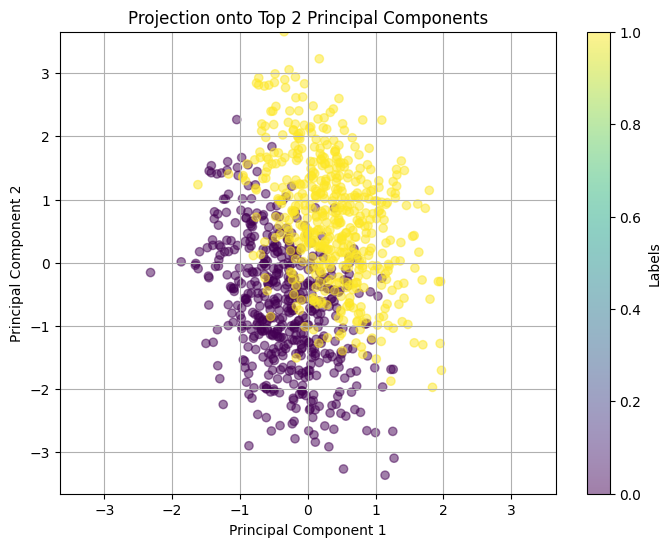

Variance of original data: tensor([1.3752, 0.5668], device='cuda:0')


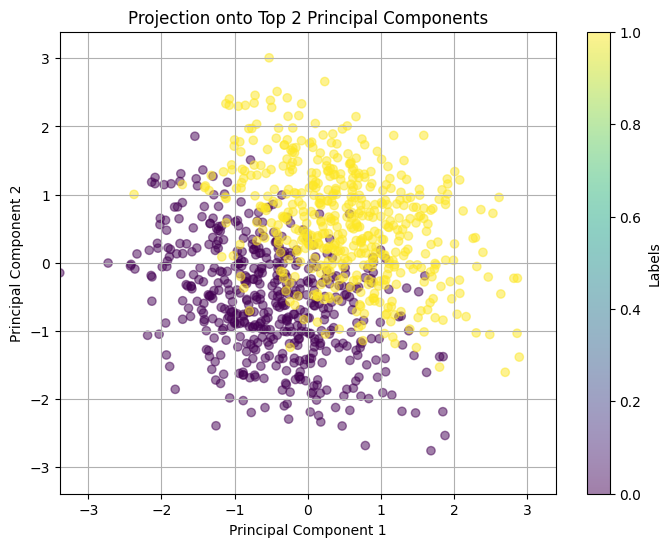

Covariance of whitened data: tensor([[1., 0.],
        [0., 1.]], device='cuda:0')
Variance of original data: tensor([1.0000, 1.0000], device='cuda:0')


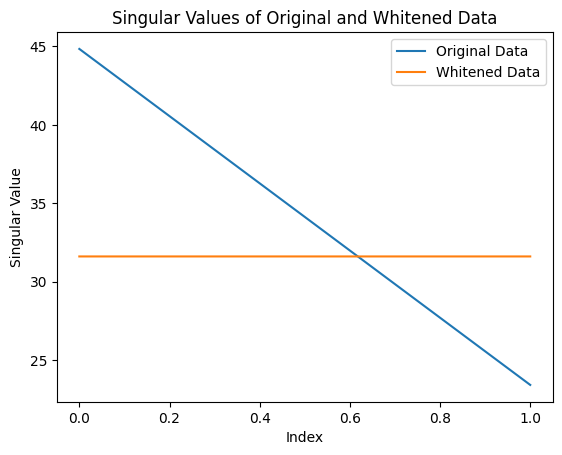

In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'



def check_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1024 ** 2} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB")
    print(f"Max Memory Cached: {torch.cuda.max_memory_reserved() / 1024 ** 2} MB")  


BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


from unlearning import probes, leace, plotting
reload(probes)
reload(plotting)
reload(leace)
# Select device: use CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)

n_samples = 500
n_features = 2
alpha = 2  # Adjust alpha to change the rate of decay
difference = 1.1

# Generate the dataset and obtain the covariance matrix used
X1, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)
X2, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = difference)

data = torch.cat((X1, X2), dim=0)

labels = torch.zeros(len(data))
labels[len(X1):] = 1

print(f"X shape: {data.shape}")    
# Whiten the dataset
X_white = leace.whiten_data_torch(data)

# Verify that the covariance of the whitened data is approximately the identity matrix
n_samples = X_white.size(0)
cov_whitened = torch.mm(X_white.T, X_white) / (n_samples - 1)
print("Covariance of the whitened data:\n", cov_whitened)

# Optionally, generate some dummy labels (e.g., for binary classes)
#labels = torch.randint(0, 2, (n_samples,), device=device)

# plot original data with top pcs

plotting.plot_top2_pcs_torch(data, labels=labels)
var_orig = torch.var(data, dim=0)
print(f"Variance of original data: {var_orig}")
# plot whitened data
plotting.plot_top2_pcs_torch(X_white, labels=labels)
var_whitened = torch.var(X_white, dim=0)
covar_whitened = torch.cov(X_white.T)
# round covar_whitened to 2 decimal places
covar_whitened = torch.round(covar_whitened * 100) / 100
print(f"Covariance of whitened data: {covar_whitened}")
print(f"Variance of original data: {var_whitened}")

# plot the covariance matrix of the whitened data
U, S, V = torch.svd(data)
U_whitened, S_whitened, V_whitened = torch.svd(X_white)     
plt.plot(S.cpu().numpy(), label='Original Data')
plt.plot(S_whitened.cpu().numpy(), label='Whitened Data')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Original and Whitened Data')
plt.legend()
plt.show()


okay, now that a linear probe is set up, let's test the accuracy on different layers in a real model
# setting up a real model 

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets
from unlearning import model_utils
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    



DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

# ========================
# 2. DATA LOADING
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

NUM_WORKERS = 4
train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



from unlearning import plotting
reload(plotting)

pos_index = 0
neg_index = 1

image_ = val_dataset[pos_index][0]
plotting.show_image(image_)

image_ = val_dataset[neg_index][0]
plotting.show_image(image_)

Files already downloaded and verified


KeyboardInterrupt: 

In [5]:
print(f"load model:")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)


model = model_utils.load_model(attr_index=1, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


print(f"evaluate model:")
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = 5)



vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]



model_layer_count = probes.get_layer_count(model)
print(f"layer count - {model_layer_count}")

# print model accuracy
accuracy = (all_preds == all_labels).float().mean()

#

load model:
Using device: cuda


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

evaluate model:


 25%|██▌       | 5/20 [00:35<01:45,  7.02s/it]

layer count - 10


Memory Allocated: 154.28564453125 MB
Max Memory Allocated: 8656.4892578125 MB
Memory Cached: 10976.0 MB
Max Memory Cached: 10976.0 MB
model accuracy - 0.9129248261451721
vals[20 ] = (tensor(2166), tensor(2872), tensor(30), tensor(52))
accuracy - (tensor(98.6339), tensor(97.6555), tensor(98.3984))


In [8]:

check_memory()
print(f"model accuracy - {accuracy}")
attribute_index = 20


print(f"vals[{attribute_index} ] = {vals[attribute_index]}")
reload(plotting)
print(f"accuracy - {plotting.compute_precision_recall_acc(vals[attribute_index])}")
# get probe accuracy 
#train_labels = train_dataset.attr
val_labels = val_dataset.attr
# attribute names 
attr_names = val_dataset.attr_names
print(f"attribute of interest - {attr_names[attribute_index]}")

positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0


N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)


# set up a probe dataset 
print(f"len pos_indices - {len(pos_indices)}")
print(f"len neg_indices - {len(neg_indices)}")
# shuffle neg_indices



attribute of interest - Male


len pos_indices - 8458
len neg_indices - 11409


/tmp/ipykernel_1921673/1187066193.py:18: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1921673/1187066193.py:19: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


Text(0.5, 1.0, 'Probe accuracy across layers')

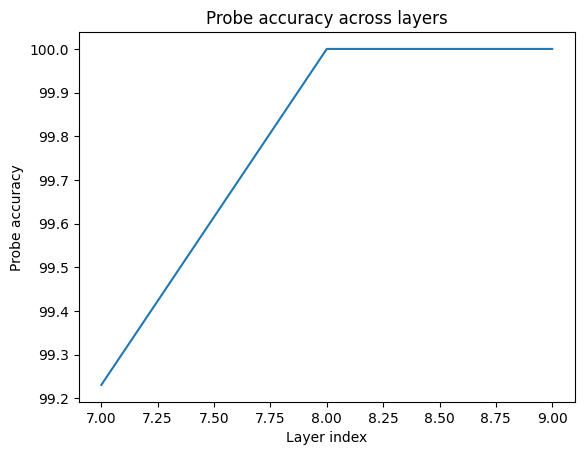

In [10]:
#print probe layer accs
reload(probes)

#probes.plot_probes(pos_indices, neg_indices, model, val_dataset, device)


# test the contrastive examples probe-ability 
(should be lower than the general probe-ability.)
## do this for each class, and then also just do it for nearby embedding points, using KNN

In [11]:
if False:
    layer_ind = 0

    probe_tup = probes.linear_probe(model=model, layer_ind = layer_ind, pos_points=pos_points[:pt_count], neg_points=neg_points[:pt_count], device=DEVICE)

    probe_acc= probe_tup[0]
    print(f"probe acc - {probe_acc}")

In [49]:
check_memory()

Memory Allocated: 78694.99072265625 MB
Max Memory Allocated: 78921.3583984375 MB
Memory Cached: 79638.0 MB
Max Memory Cached: 79680.0 MB


In [14]:
layer_ind = 8
positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0
reload(probes)

N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)



probe_dataset, probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices[:N], neg_indices=neg_indices[:N], dataset = val_dataset, device = device, verbose = True)

print(f"probe_dataset - {probe_dataset.shape}")
print(f"probe_labels - {probe_labels.shape}")

generating loader from scratch
batching embeddings


/tmp/ipykernel_1921673/3454203930.py:11: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1921673/3454203930.py:12: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
probe_dataset - torch.Size([2000, 2048])
probe_labels - torch.Size([2000])


In [15]:
check_memory()

probe_dataset[0].shape

Memory Allocated: 154.28564453125 MB
Max Memory Allocated: 8656.4892578125 MB
Memory Cached: 10990.0 MB
Max Memory Cached: 10990.0 MB


torch.Size([2048])

### test embedding search space

embedding 1000/2000
embedding 1100/2000
embedding 1200/2000
embedding 1300/2000
embedding 1400/2000
embedding 1500/2000
embedding 1600/2000
embedding 1700/2000
embedding 1800/2000
embedding 1900/2000


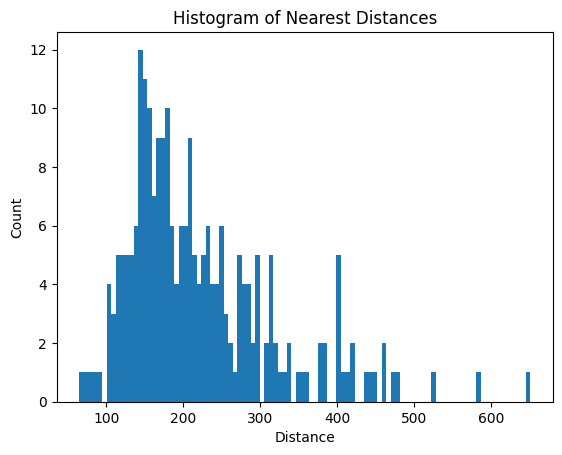

In [18]:
# search for the first image 
from unlearning import contrastive_examples

reload(contrastive_examples)
embedding = probe_dataset[-1]

# BEEP BOOP BAAP - HACK - I am in the middle of pulling this out into a function
search_engine = contrastive_examples.build_positive_examples_db(probe_dataset, probe_labels, model, layer_ind)

search_engine.search_embedding(query_embedding = embedding, top_k=5)
from collections import defaultdict
seen = set()
nearest_distances = defaultdict(lambda: 1000000)

for ii, (embedding, embedding_label) in enumerate(zip(probe_dataset, probe_labels)):
    if embedding_label == 1:
        continue
    if ii % (N//10) == 0:
        print(f"embedding {ii}/{N_}")
    
    results = search_engine.search_embedding(query_embedding = embedding, top_k=5)
    for (ind, dist) in results:
        if ind == ii:
            continue
        nearest_distances[ind] = min(nearest_distances[ind], dist)

# plot hist of nearest_distances

plt.hist(list(nearest_distances.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()

### compute these distances over all val points

In [21]:
all_neg_indices = torch.where(negative_attributes)[0]

len(all_neg_indices)

positive_centroid = torch.mean(probe_dataset[probe_labels == 1], dim=0)
positive_centroid.shape
positive_centroid.device

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [22]:
reload(probes)
nearest_distances = defaultdict(lambda: 1000000)
distance_to_centroid = {}

all_neg_indices = torch.where(negative_attributes)[0]
# shuffle 
all_neg_indices = np.array(all_neg_indices)
np.random.shuffle(all_neg_indices)

indices_to_check =all_neg_indices[:4_500]

for neg_ii, neg_image_index in enumerate(indices_to_check):
    if neg_ii % (len(indices_to_check)//10) == 0:
        print(f"embedding {neg_ii}/{len(indices_to_check)}")
    
    image = val_dataset[neg_image_index][0]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    embedding = probes.get_flattened_embedding(model, layer_ind = layer_ind, x = image)
    results = search_engine.search_embedding(query_embedding = embedding, top_k=3)
    min_index = np.argmin([dist for (pos_ind, dist) in results])    
    pos_ind, min_dist = results[min_index]
    nearest_distances[neg_image_index] = min_dist
    if False:
        for (pos_ind, dist) in results:
            if ind == neg_ii:
                continue
            existing_dist = nearest_distances[neg_image_index]
            nearest_distances[neg_image_index] = min(existing_dist, dist)

    # report distance to centroid
    distance_to_centroid[neg_image_index] = torch.norm(positive_centroid - embedding.cpu()).item()

/tmp/ipykernel_1921673/3534759443.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_neg_indices = np.array(all_neg_indices)


embedding 0/4500
embedding 450/4500
embedding 900/4500
embedding 1350/4500
embedding 1800/4500
embedding 2250/4500
embedding 2700/4500
embedding 3150/4500
embedding 3600/4500
embedding 4050/4500


## todo : create a function that computes the `ordered_nearest_distances` (using centroid), efficiently

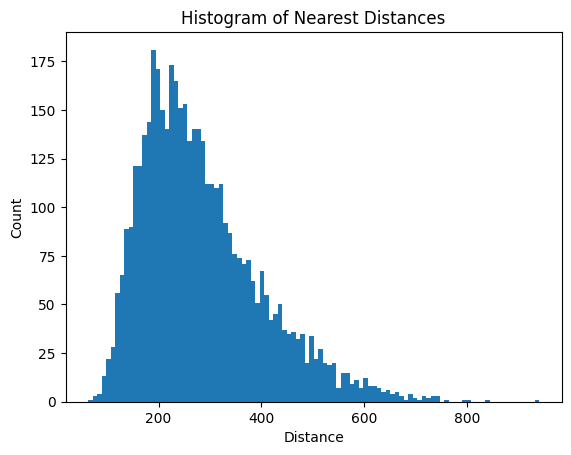

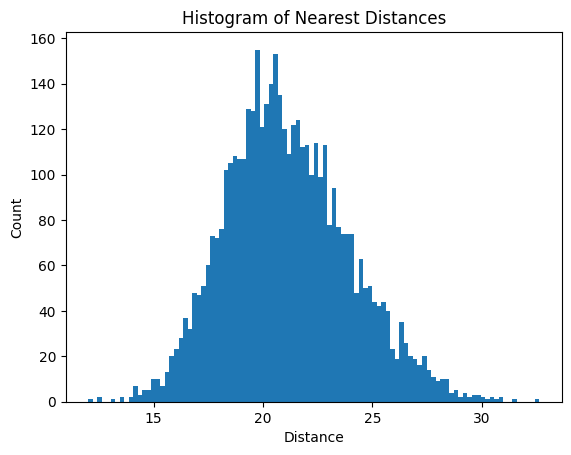

4500
pearson_corr between ranking of nearest distances to centroid distance - 0.9850781628996719


In [23]:
# plot nearest_distances
# plot hist of nearest_distances

plt.hist(list(nearest_distances.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()


# plot distance_to_centroid
plt.hist(list(distance_to_centroid.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()


# order nearest_distances
ordered_nearest_distances = sorted(nearest_distances.items(), key=lambda x: x[1])
# order distance_to_centroid
ordered_distance_to_centroid = sorted(distance_to_centroid.items(), key=lambda x: x[1])
length = min(len(ordered_nearest_distances), len(ordered_distance_to_centroid))

print(length)
# print the pearson rank correlation between the two
import scipy.stats as stats
pearson_corr, _ = stats.pearsonr([x[1] for x in ordered_nearest_distances[:length]], [x[1] for x in ordered_distance_to_centroid[:length]])
print(f"pearson_corr between ranking of nearest distances to centroid distance - {pearson_corr}")


## observe that picking 1-NN embedding distance to any point, or just to the center has a very similar ranking: 

pearson_corr between ranking of nearest distances to centroid distance - 0.9843334185769756


In [24]:
layer_ind 

8

In [25]:
# pick top 1000 of 
N = len(pos_indices)
#N = 500# 1000
print(f"N - {N}")
N = min(N, len(ordered_nearest_distances), 1000 )

closest_neg_indices = [int(ordered_nearest_distances[i][0]) for i in range(N)]
closest_neg_indices = np.array(closest_neg_indices)


## base probe
#shuffle neg_indices, choose 1000 random points from neg_indices
neg_indices_normal = np.random.choice(all_neg_indices, size=N, replace=False)


normal_probe_dataset, normal_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices, neg_indices=neg_indices_normal, dataset =val_dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)



# create probe dataset of these closest_neg_attributes, and positive images

closest_probe_dataset, closest_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices, neg_indices=closest_neg_indices, dataset =val_dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)
    
#val_dataset[0][0].shape



N - 8458
generating loader from scratch
batching embeddings


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing batch 1/34
Processing batch 5/34
Processing batch 9/34
Processing batch 13/34
Processing batch 17/34
Processing batch 21/34
Processing batch 25/34
Processing batch 29/34
Processing batch 33/34
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/34
Processing batch 5/34
Processing batch 9/34
Processing batch 13/34
Processing batch 17/34
Processing batch 21/34
Processing batch 25/34
Processing batch 29/34
Processing batch 33/34
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [26]:
# test probe
reload(probes)


print(f"Probe on random vals")

linear_probe_random = probes.test_linear_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)
MLP_probe_random = probes.test_MLP_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_random_acc - {linear_probe_random[0]}")
print(f"\tMLP_probe_random_acc - {MLP_probe_random[0]}")


print(f"Probe on closest vals")
linear_probe_closest = probes.test_linear_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

MLP_probe_closest = probes.test_MLP_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_closest_acc - {linear_probe_closest[0]}")
print(f"\tMLP_probe_closest_acc - {MLP_probe_closest[0]}")


Probe on random vals
	linear_probe_random_acc - 99.27046298980713
	MLP_probe_random_acc - 99.88369941711426
Probe on closest vals
	linear_probe_closest_acc - 98.42461347579956
	MLP_probe_closest_acc - 99.7991144657135


In [27]:
# now test probe accuracy with better contrastive examples chosen

embedding_1, image_index_1 = probe_dataset[0], 0
search_engine.add_embedding(embedding = embedding_1, image_index = image_index_1)

if False:
    search_engine = ImageSearch()
    search_engine.load_images_from_directory('path_to_your_image_folder')

    results = search_engine.search_image('path_to_query_image.jpg', top_k=3)
    for path, dist in results:
        print(f"Matched Image: {path}, Distance: {dist}")


## If we minimize probe accuracy on train set, how does that effect the probe accuracy on the val set?

In [28]:
for i, attr_name in enumerate(train_dataset.attr_names):
    print(f"attribute {i} - {attr_name}")


model_attribute_ind = 0
probe_attribute_index = 13


print(f"attribute = {train_dataset.attr_names[attribute_index]}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)

layer_count = probes.get_layer_count(model)
layer_ind = layer_count - 2


attribute 0 - 5_o_Clock_Shadow
attribute 1 - Arched_Eyebrows
attribute 2 - Attractive
attribute 3 - Bags_Under_Eyes
attribute 4 - Bald
attribute 5 - Bangs
attribute 6 - Big_Lips
attribute 7 - Big_Nose
attribute 8 - Black_Hair
attribute 9 - Blond_Hair
attribute 10 - Blurry
attribute 11 - Brown_Hair
attribute 12 - Bushy_Eyebrows
attribute 13 - Chubby
attribute 14 - Double_Chin
attribute 15 - Eyeglasses
attribute 16 - Goatee
attribute 17 - Gray_Hair
attribute 18 - Heavy_Makeup
attribute 19 - High_Cheekbones
attribute 20 - Male
attribute 21 - Mouth_Slightly_Open
attribute 22 - Mustache
attribute 23 - Narrow_Eyes
attribute 24 - No_Beard
attribute 25 - Oval_Face
attribute 26 - Pale_Skin
attribute 27 - Pointy_Nose
attribute 28 - Receding_Hairline
attribute 29 - Rosy_Cheeks
attribute 30 - Sideburns
attribute 31 - Smiling
attribute 32 - Straight_Hair
attribute 33 - Wavy_Hair
attribute 34 - Wearing_Earrings
attribute 35 - Wearing_Hat
attribute 36 - Wearing_Lipstick
attribute 37 - Wearing_Necklac

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

evaluate model:


 25%|██▌       | 5/20 [00:31<01:34,  6.28s/it]


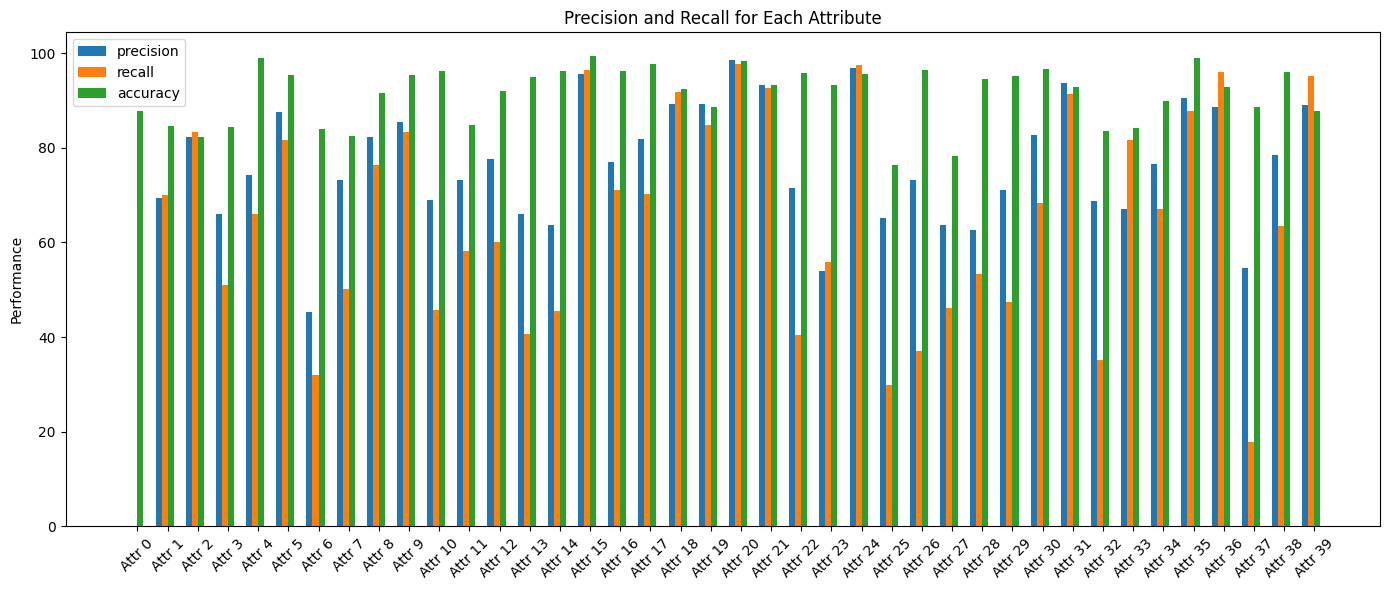

In [29]:
# evaluate model
print(f"evaluate model:")
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = 5)
# plot bars
vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]
vals = np.array(vals)

reload(plotting)
plotting.generate_precision_recall_chart(vals)

In [30]:
# okay let's run GA on the closest_neg_indices, from the train set
reload(probes)

train_dataset
train_labels = train_dataset.attr
#print(f"train_dataset - {train_dataset}")
print(f"train_labels - {train_labels.shape}")

# 1. construct probe dataset for train_dataset 
# 2. make a quick function for compute "closest_counterfactuals "

print(f"attribute of interest - {attr_names[attribute_index]}")


positive_attributes = train_labels[:, probe_attribute_index] == 1
negative_attributes = train_labels[:, probe_attribute_index] == 0
pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]


N = min(2000, len(pos_indices), len(neg_indices))


val_positive_attributes = val_labels[:, probe_attribute_index] == 1
val_negative_attributes = val_labels[:, probe_attribute_index] == 0
val_pos_indices = torch.where(val_positive_attributes)[0]
val_neg_indices = torch.where(val_negative_attributes)[0]

val_N = min(1000, len(val_pos_indices), len(val_neg_indices))
# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)

# shuffle pos_indices
np.random.shuffle(val_pos_indices)
np.random.shuffle(val_neg_indices)

print(f"pos indices - {len(pos_indices)}")
print(f"neg indices - {len(neg_indices)}")

embedding_size = probes.get_embedding_size(model, layer_ind = layer_ind)
print(f"layer: { layer_ind} ; embedding size: {embedding_size}")

print(f"compute train probe set:")

probe_dataset, probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices[:N], neg_indices=neg_indices[:N], dataset = train_dataset, device = device, verbose = True)

print(f"compute val probe set:")
val_probe_dataset, val_probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=val_pos_indices[:val_N], neg_indices=val_neg_indices[:val_N], dataset = val_dataset, device = device, verbose = True)


train_labels - torch.Size([162770, 40])
attribute of interest - Male


/tmp/ipykernel_1921673/2049898676.py:31: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_1921673/2049898676.py:32: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


pos indices - 9389
neg indices - 153381
model_device: cuda:0
layer: 8 ; embedding size: 2048
compute train probe set:
generating loader from scratch
batching embeddings


/tmp/ipykernel_1921673/2049898676.py:35: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(val_pos_indices)
/tmp/ipykernel_1921673/2049898676.py:36: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(val_neg_indices)
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get 

Processing batch 1/8
Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8
generating loader from scratch
batching embeddings
Processing batch 1/8
Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8
compute val probe set:
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [31]:
shapes = set()
for i in range(100):
    shapes.add(train_dataset[i][0].shape)

print(shapes)


{torch.Size([3, 218, 178])}


In [32]:
reload(probes)
for l_ in range(layer_count):
    input_dummy_shape =torch.Size([1, 3, 218, 178])
    #print(input_dummy_shape)

    embedding_size = probes.get_embedding_size(model, l_, input_dummy_shape=input_dummy_shape)
    print(f"layer: {l_} ; embedding size: \t\t{embedding_size}")

        
    embedding_size = probes.get_embedding_size(model, l_, )
    print(f"layer: {l_} ; default embedding size: \t{embedding_size}")


model_device: cuda:0
layer: 0 ; embedding size: 		620864
model_device: cuda:0
layer: 0 ; default embedding size: 	620864
model_device: cuda:0
layer: 1 ; embedding size: 		620864
model_device: cuda:0
layer: 1 ; default embedding size: 	620864
model_device: cuda:0
layer: 2 ; embedding size: 		620864
model_device: cuda:0
layer: 2 ; default embedding size: 	620864
model_device: cuda:0
layer: 3 ; embedding size: 		158400
model_device: cuda:0
layer: 3 ; default embedding size: 	158400
model_device: cuda:0
layer: 4 ; embedding size: 		633600
model_device: cuda:0
layer: 4 ; default embedding size: 	633600
model_device: cuda:0
layer: 5 ; embedding size: 		329728
model_device: cuda:0
layer: 5 ; default embedding size: 	329728
model_device: cuda:0
layer: 6 ; embedding size: 		172032
model_device: cuda:0
layer: 6 ; default embedding size: 	172032
model_device: cuda:0
layer: 7 ; embedding size: 		86016
model_device: cuda:0
layer: 7 ; default embedding size: 	86016
model_device: cuda:0
layer: 8 ; em

In [33]:
pt_count= 1000
reload(probes)
#for layer_ind in [0,8,9]:


pos_subset = Subset(train_dataset, pos_indices)
pos_loader = DataLoader(pos_subset, batch_size=256, shuffle=False, num_workers=4)
neg_subset = Subset(train_dataset, neg_indices)
neg_loader = DataLoader(neg_subset, batch_size=256, shuffle=False, num_workers=4)

loaders = (pos_loader, neg_loader)
loaders= None
probe_accs= []
layers_ = [0,4, 7,8,9]
for layer_ind in layers_:
    embedding_size = probes.get_embedding_size(model, layer_ind)
    print(f"layer_ind - {layer_ind} ; embedding_size : {embedding_size}")

    probe_acc = probes.mlp_probe(model=model, layer_ind = layer_ind, pos_indices=pos_indices[:pt_count], neg_indices=neg_indices[:pt_count], dataset= train_dataset,device=DEVICE, verbose = True, num_epochs = 1000, loaders=loaders)[0]
    print(f"probe acc - {probe_acc}")
    probe_accs.append(probe_acc)
    print("----")

model_device: cuda:0
layer_ind - 0 ; embedding_size : 620864
generating loader from scratch
batching embeddings


Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
probe_dataset shape: torch.Size([2000, 620864])
Epoch [100/1000], Loss: 10.0188
Epoch [200/1000], Loss: 7.4000
Epoch [300/1000], Loss: 7.4000
Epoch [400/1000], Loss: 7.4000
Epoch [500/1000], Loss: 7.4000
Epoch [600/1000], Loss: 7.4000
Epoch [700/1000], Loss: 7.4000
Epoch [800/1000], Loss: 7.4000
Epoch [900/1000], Loss: 7.4000
Epoch [1000/1000], Loss: 7.4000
Accuracy: 92.60%
probe acc - 92.60000586509705
----
model_device: cuda:0
layer_ind - 4 ; embedding_size : 633600
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
probe_dataset shape: torch.Size([2000,

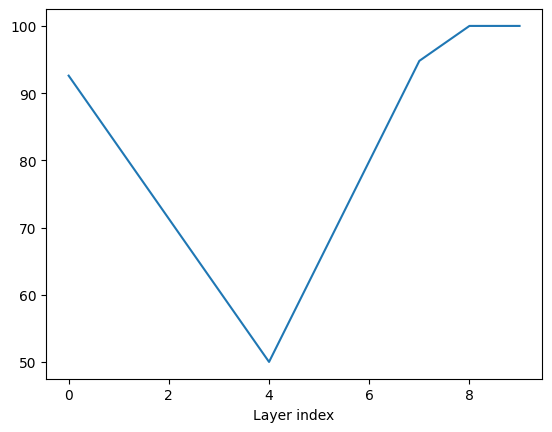

In [34]:
# plot probe accs
plt.plot(layers_, probe_accs)
plt.xlabel("Layer index")
plt.show()

In [35]:
check_memory()

Memory Allocated: 251.75146484375 MB
Max Memory Allocated: 8753.95458984375 MB
Memory Cached: 22784.0 MB
Max Memory Cached: 22784.0 MB


In [36]:
# train MLP on probe_dataset
mlp_probe = probes.test_MLP_probe(probe_dataset= probe_dataset, probe_labels = probe_labels, model= model, num_epochs= 1000, verbose= True)
# (probe_acc, probe_dataset, probe_labels, probe_model)
mlp_probe

linear_probe = probes.test_linear_probe(probe_dataset= probe_dataset, probe_labels = probe_labels, model= model, num_epochs= 1000, verbose= True)

Epoch [100/1000], Loss: 0.2229
Epoch [200/1000], Loss: 0.1727
Epoch [300/1000], Loss: 0.1238
Epoch [400/1000], Loss: 0.0945


KeyboardInterrupt: 

# Let's do iterative GA on the probes

In [37]:
# copy the model
import copy
original_model = copy.deepcopy(model)

In [38]:
from torch.utils.data import Dataset

class CustomLabeledDataset(Dataset):
    def __init__(self, base_dataset, indices, custom_labels):
        self.base_dataset = base_dataset
        self.indices = indices
        self.custom_labels = custom_labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data, _ = self.base_dataset[self.indices[idx]]  # Ignore original label
        label = self.custom_labels[idx]
        return data, label
    

pt_count = min(len(pos_indices), len(neg_indices), pt_count)
probe_indices = torch.concat((pos_indices[:pt_count], neg_indices[:pt_count]), dim=0)
probe_labels = torch.concat([torch.ones(pt_count), torch.zeros(pt_count)], dim=0)

probe_dataset = CustomLabeledDataset(
    base_dataset=train_dataset,
    indices=probe_indices,
    custom_labels=probe_labels
)

# create val probe dataset :
val_probe_indices = torch.concat((val_pos_indices[:val_N], val_neg_indices[:val_N]), dim=0)
val_probe_labels = torch.concat([torch.ones(val_N), torch.zeros(val_N)], dim=0)
val_probe_dataset = CustomLabeledDataset(
    base_dataset=val_dataset,
    indices=val_probe_indices,
    custom_labels=val_probe_labels
)

from torch.utils.data import DataLoader

probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True, num_workers=4)

val_probe_loader = DataLoader(val_probe_dataset, batch_size=64, shuffle=True, num_workers=4)

In [39]:
reload(probes)
# load model 
print(f"model_attribute_ind - {model_attribute_ind}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


model_attribute_ind - 0


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

In [40]:
# 
reload(probes)
layer_ind = 8
### set up an MLP probe



def eval_probe(model, probe_model, val_probe_loader, device, max_steps = None):
    # evaluate probe model on val:
    probe_model.eval()
    correct = 0
    total = 0
    report_every = (len(val_probe_loader) // 10) +1
    with torch.no_grad():
        for val_step, (images, labels) in enumerate(val_probe_loader):
            if val_step % report_every == 0:
                print(f"val step - {val_step}/ {len(val_probe_loader)}")
            if max_steps and (val_step > max_steps):
                break 

            embeddings = []
            for image in images:
                embedding = probes.get_flattened_embedding(model, layer_ind=layer_ind, x=image.unsqueeze(0).to(device))
                embeddings.append(embedding)
            embeddings = torch.cat(embeddings, dim=0)
            
            outputs = probe_model(embeddings)
            predicted = (outputs > 0.5).float()
            
            total += labels.size(0)
            correct += (predicted.squeeze() == labels.to(device)).sum().item()
    return correct, total


def train_probe(probe_model, model, probe_dataset, probe_labels, layer_ind, device):
    embedding_dataset =[]
    for ii, (image, label) in enumerate(probe_dataset):
        embedding = probes.get_flattened_embedding(model, layer_ind=layer_ind, x=image.unsqueeze(0).to(device))
        embedding_dataset.append((embedding, label))
        if ii % (len(probe_dataset)//10) == 0:
            print(f"embedding {ii}/{len(probe_dataset)}")

    embedding_dataset= torch.cat([x[0] for x in embedding_dataset], dim=0)
    embedding_dataset.shape
    #probe_model = probes.MLP(input_dim=embedding_size, hidden_dim=128)
    #probe_model = probe_model.to(device)


    probe_acc, probe_model = probes.train_model(probe_model, embedding_dataset, probe_labels, num_epochs=100)
    
    return probe_model


embedding_size = probes.get_embedding_size(model, layer_ind = layer_ind)

probe_model = probes.MLP(input_dim=embedding_size, hidden_dim=128)
probe_model = probe_model.to(device)

probe_model = train_probe(probe_model, model, probe_dataset, probe_labels, layer_ind, device)
correct, total = eval_probe(model, probe_model, val_probe_loader, device, max_steps = 6)

print(f"valuation : Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")

# print the train set acc:
correct, total = eval_probe(model, probe_model, probe_loader, device, max_steps = 6)
print(f"train : Accuracy of the probe model on the train set: {100 * correct / total:.2f}%")



model_device: cuda:0
embedding 0/2000
embedding 200/2000
embedding 400/2000
embedding 600/2000
embedding 800/2000
embedding 1000/2000
embedding 1200/2000
embedding 1400/2000
embedding 1600/2000
embedding 1800/2000
Epoch [100/100], Loss: 0.5569
Accuracy: 76.95%
val step - 0/ 32
val step - 4/ 32
valuation : Accuracy of the probe model on the validation set: 73.88%
val step - 0/ 32
val step - 4/ 32
train : Accuracy of the probe model on the train set: 75.67%


In [41]:

from unlearning import iterative_ga
#GA_based_concept_optimization
model = iterative_ga.GA_based_concept_optimization(model, probe_model, probe_loader, device, layer_ind)




unfreezing layer 7
unfreezing layer 8
Unfrozen parameters count: 14964736
Epoch [1], Step [1/32], Loss: 0.5120
Epoch [1], Step [8/32], Loss: 0.7136
Epoch [1], Step [15/32], Loss: 1.0391
Epoch [1], Step [22/32], Loss: 0.6611
Epoch [1], Step [29/32], Loss: 1.2668
0 -- Loss: 1.9921
Epoch [2], Step [1/32], Loss: 1.6918
1 -- Loss: 2.1734


In [42]:
print(f"probe accuracy")
correct, total = eval_probe(model, probe_model, probe_loader, device, max_steps =10)
print(f"total - {total}; correct - {correct}")
print(f"Accuracy of the model on the train set: {100 * correct / total:.2f}%")

# evaluate on val
print(f"val probe accuracy")
correct, total = eval_probe(model, probe_model, val_probe_loader, device, max_steps =10)
print(f"total - {total}; correct - {correct}")
print(f"Accuracy of the model on the validation set: {100 * correct / total:.2f}%")

probe accuracy
val step - 0/ 32
val step - 4/ 32
val step - 8/ 32
total - 704; correct - 478
Accuracy of the model on the train set: 67.90%
val probe accuracy
val step - 0/ 32
val step - 4/ 32
val step - 8/ 32
total - 704; correct - 467
Accuracy of the model on the validation set: 66.34%


 60%|██████    | 12/20 [00:55<00:36,  4.61s/it]


----


 60%|██████    | 12/20 [00:50<00:33,  4.18s/it]

---


Text(0.5, 1.0, 'Model Accuracy Before and After running GA on probe accuracy')

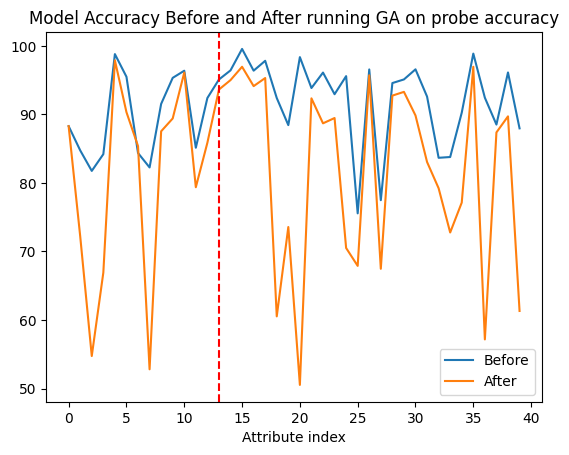

In [43]:
# test model accuracy in general
max_rounds= 12
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = max_rounds)
# plot bars
vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]
vals = np.array(vals)

print(f"----")
accs_after = [plotting.compute_precision_recall_acc(val)[2] for val in vals]

original_preds, original_labels = model_utils.evaluate(original_model, val_loader, max_rounds = max_rounds)
original_vals = [(model_utils.get_TP_TN_FP_FN(i, original_labels, original_preds)[0]) for i in range(40)]
original_vals = np.array(original_vals)

accs_before = [plotting.compute_precision_recall_acc(val)[2] for val in original_vals]
print("---")
# plot before and after
plt.plot(accs_before, label='Before')
plt.plot(accs_after, label='After')
plt.legend()
plt.xlabel("Attribute index")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("Model Accuracy Before and After running GA on probe accuracy")

{'5_o_Clock_Shadow': np.int64(18177), 'Arched_Eyebrows': np.int64(43278), 'Attractive': np.int64(83603), 'Bags_Under_Eyes': np.int64(33280), 'Bald': np.int64(3713), 'Bangs': np.int64(24685), 'Big_Lips': np.int64(39213), 'Big_Nose': np.int64(38341), 'Black_Hair': np.int64(38906), 'Blond_Hair': np.int64(24267), 'Blurry': np.int64(8362), 'Brown_Hair': np.int64(33192), 'Bushy_Eyebrows': np.int64(23386), 'Chubby': np.int64(9389), 'Double_Chin': np.int64(7571), 'Eyeglasses': np.int64(10521), 'Goatee': np.int64(10337), 'Gray_Hair': np.int64(6896), 'Heavy_Makeup': np.int64(62555), 'High_Cheekbones': np.int64(73645), 'Male': np.int64(68261), 'Mouth_Slightly_Open': np.int64(78486), 'Mustache': np.int64(6642), 'Narrow_Eyes': np.int64(18869), 'No_Beard': np.int64(135779), 'Oval_Face': np.int64(46101), 'Pale_Skin': np.int64(7005), 'Pointy_Nose': np.int64(44846), 'Receding_Hairline': np.int64(13040), 'Rosy_Cheeks': np.int64(10525), 'Sideburns': np.int64(9156), 'Smiling': np.int64(78080), 'Straight_H

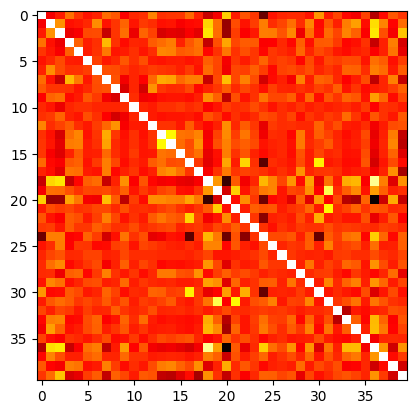

counts sorted - [np.int64(3713), np.int64(6642), np.int64(6896), np.int64(7005), np.int64(7571), np.int64(8039), np.int64(8362), np.int64(9156), np.int64(9389), np.int64(10337), np.int64(10521), np.int64(10525), np.int64(11890), np.int64(13040), np.int64(18177), np.int64(18869), np.int64(19764), np.int64(23386), np.int64(24267), np.int64(24685), np.int64(30362), np.int64(33192), np.int64(33280), np.int64(33947), np.int64(38341), np.int64(38906), np.int64(39213), np.int64(43278), np.int64(44846), np.int64(46101), np.int64(51982), np.int64(62555), np.int64(68261), np.int64(73645), np.int64(76437), np.int64(78080), np.int64(78486), np.int64(83603), np.int64(126788), np.int64(135779)]


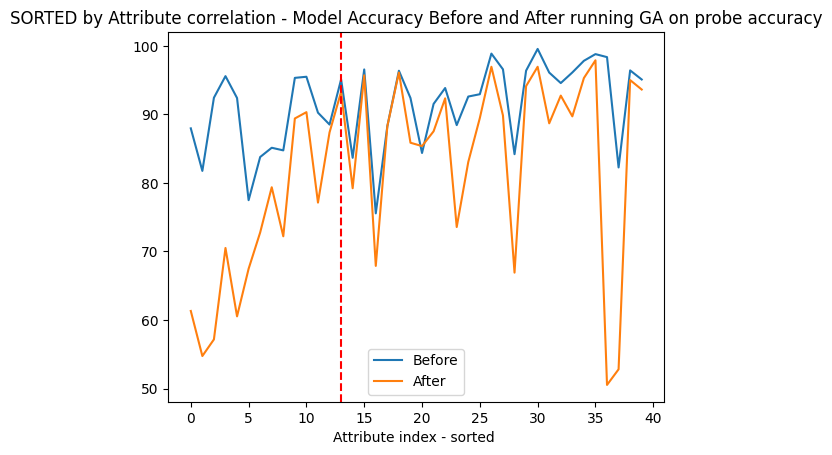

Text(0.5, 1.0, 'SORTED by # of elements - Model Accuracy Before and After running GA on probe accuracy')

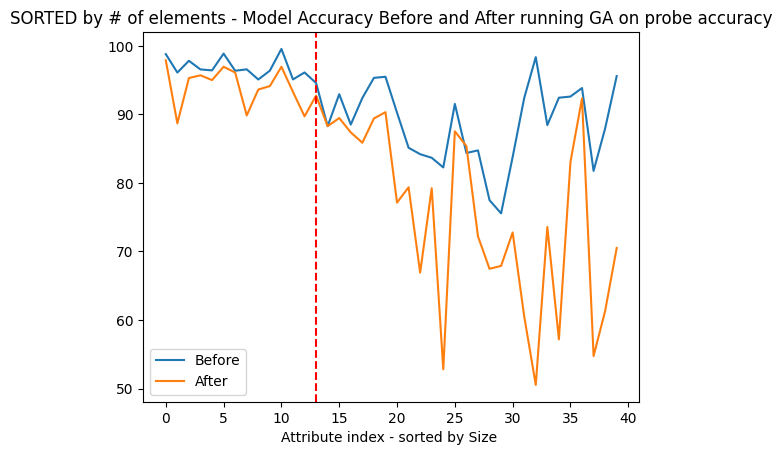

In [44]:
# can we sort the indices by correlation with the attribute of interest?
train_labels = train_dataset.attr
subset_targets = train_labels

subset_targets_np = subset_targets.numpy()


counts = np.sum(subset_targets.numpy(), axis=0)
attribute_to_count = {train_dataset.attr_names[i] : counts[i] for i in range(len(counts))}
# Sort attributes by count
#sorted_attributes = [attribute_names[i] for i in sort_attribute_indices]
#sorted_attributes = sorted

print(attribute_to_count)
correlation_matrix = np.corrcoef(subset_targets_np, rowvar=False)

# show correlation_matrix
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.show()
correlation_with_attr = correlation_matrix[:, probe_attribute_index]
arg_sort_correlation  = np.argsort(correlation_with_attr)
arg_sort_count = np.argsort(counts)
print(f"counts sorted - {[counts[i] for i in arg_sort_count]}")
accs__correlation_sorted_before = [accs_before[i] for i in arg_sort_correlation]
accs__correlation_sorted_after = [accs_after[i] for i in arg_sort_correlation]
plt.plot(accs__correlation_sorted_before, label='Before')
plt.plot(accs__correlation_sorted_after, label='After')

plt.legend()
plt.xlabel("Attribute index - sorted ")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("SORTED by Attribute correlation - Model Accuracy Before and After running GA on probe accuracy")
plt.show()


accs__size_sorted_before = [accs_before[i] for i in arg_sort_count]
accs__size_sorted_after = [accs_after[i] for i in arg_sort_count]
plt.plot(accs__size_sorted_before, label='Before')
plt.plot(accs__size_sorted_after, label='After')

plt.legend()
plt.xlabel("Attribute index - sorted by Size ")
# vert line at probe_attribute_index
plt.axvline(x=probe_attribute_index, color='r', linestyle='--')
plt.title("SORTED by # of elements - Model Accuracy Before and After running GA on probe accuracy")

### Testing an idea: GA only in the direction of GD on a different loss
1. compute GD on normal loss function, compute a subspace (PCA), for a specific layer
2. 



In [48]:
# run GD on probe dataset with regular labels

from unlearning import iterative_ga
reload(iterative_ga)

attribute_index
# get dataloader that has no attribute from attribute_index

retain_mask = train_labels[:, attribute_index] == 0
retain_indices = torch.where(retain_mask)[0]
retain_subset = Subset(train_dataset, retain_indices)
retain_loader = DataLoader(retain_subset, batch_size=256, shuffle=False, num_workers=4)
# run GD on this retain_loader
model.train()

embeddings = []


###
# Beep boop baap :
# we will compute the embeddings, then run SVD of rank ~500,;
# What we need is that the GA gradients are POSITIVELY aligned with the GD steps.
# If these are not aligned, then we haven't done anything with this projection.
# TODO - to test: what is the rank of these embeddings! (check that it is small!) 
####

reload(probes)
# load model 
print(f"model_attribute_ind - {model_attribute_ind}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)

all_embeddings = []
for retain_ind, (images, labels) in enumerate(retain_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    # Forward pass through model to get embeddings
    embeddings = iterative_ga.get_flattened_embedding__model(model, images, layer_ind=layer_ind)
    all_embeddings.append(embeddings)
    print(f"embedding shape - {embeddings.shape}")
    # minimize loss 
    if retain_ind > 4:
        break 

# TODO - implement positively-clamped gradients!


model_attribute_ind - 0
embedding shape - torch.Size([256, 2048])
embedding shape - torch.Size([256, 2048])
embedding shape - torch.Size([256, 2048])
embedding shape - torch.Size([256, 2048])


OutOfMemoryError: CUDA out of memory. Tried to allocate 608.00 MiB. GPU 0 has a total capacity of 79.10 GiB of which 300.50 MiB is free. Including non-PyTorch memory, this process has 78.79 GiB memory in use. Of the allocated memory 76.85 GiB is allocated by PyTorch, and 943.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

already concated
all_embeddings shape - torch.Size([1536, 2048])


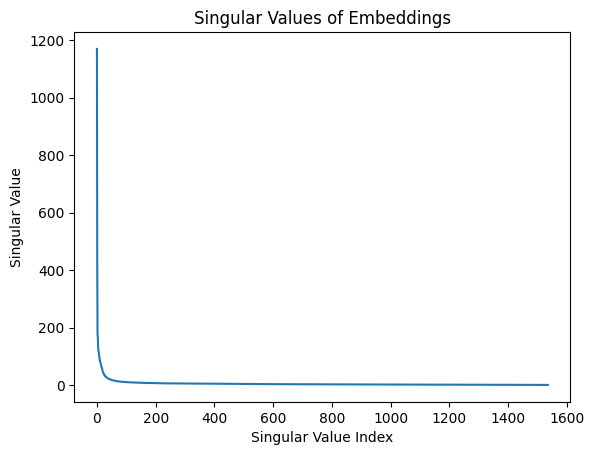

In [62]:
# run SVD on all_embeddings
try:
    all_embeddings = torch.cat(all_embeddings, dim=0)
except:
    print("already concated")
# to cuda 
all_embeddings = all_embeddings.to(device)

print(f"all_embeddings shape - {all_embeddings.shape}")
U,S, V = torch.linalg.svd(all_embeddings)
# plot S
plt.plot(S.detach().cpu().numpy())
plt.xlabel("Singular Value Index")
plt.ylabel("Singular Value")
plt.title("Singular Values of Embeddings")
plt.show()

In [69]:



def project_down(data, proj_matrix):
    # (n2 x d)
    return torch.matmul(data, proj_matrix)

def project_back(data, proj_matrix):
    return torch.matmul(data, proj_matrix.T)

def positive_projections(gradient, proj_matrix):
    # x is your vector to project (shape should match columns of U)
    projections = project_down(gradient, proj_matrix)
    
    # Set negative components to 0 clearly
    projections = torch.clamp(projections, min=0) # clamp it while it's in projected space, as this confirms alignment with the projection matrix
    
    lifted = project_back(projections, proj_matrix)
    return lifted
if False:
    k = 500
    _, _ , V = compute_positive_subspace(model, retain_loader, layer_ind)
    proj_matrix = V[:,:k]

print(f"load model")

reload(probes)
# load model 
print(f"model_attribute_ind - {model_attribute_ind}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


probe_model = probes.MLP(input_dim=embedding_size, hidden_dim=128)
probe_model = probe_model.to(device)

print(f"train probe")
probe_model = train_probe(probe_model, model, probe_dataset, probe_labels, layer_ind, device)
print(f"eval probe")
correct, total = eval_probe(model, probe_model, val_probe_loader, device, max_steps = 6)
print(f"Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")
print(f"run GA probe")
model = iterative_ga.iterative_probe_GA(model, probe_model, probe_loader, device, layer_ind, lr = 5e-2, epochs = 10, max_loss = 1.5)

# eval probe again
print(f"eval probe")
correct, total = eval_probe(model, probe_model, val_probe_loader, device, max_steps = 6)
print(f"Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")


load model
model_attribute_ind - 0


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

train probe
embedding 0/2000
embedding 200/2000
embedding 400/2000
embedding 600/2000
embedding 800/2000
embedding 1000/2000
embedding 1200/2000
embedding 1400/2000
embedding 1600/2000
embedding 1800/2000
Epoch [100/100], Loss: 0.6882
Accuracy: 75.95%
eval probe


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val step - 0/ 32
val step - 4/ 32
run GA probe
unfreezing layer 7
unfreezing layer 8
Unfrozen parameters count: 14964736
Epoch [1], Step [1/32], Loss: 0.6687
Epoch [1], Step [8/32], Loss: 0.6728
Epoch [1], Step [15/32], Loss: 0.6819
Epoch [1], Step [22/32], Loss: 0.6823
Epoch [1], Step [29/32], Loss: 0.6849
0 -- Loss: 0.6782
Epoch [2], Step [1/32], Loss: 0.6855
Epoch [2], Step [8/32], Loss: 0.6904
Epoch [2], Step [15/32], Loss: 0.6916
Epoch [2], Step [22/32], Loss: 0.7002
Epoch [2], Step [29/32], Loss: 0.7047
1 -- Loss: 0.7212
Epoch [3], Step [1/32], Loss: 0.7179
Epoch [3], Step [8/32], Loss: 0.7127
Epoch [3], Step [15/32], Loss: 0.7189
Epoch [3], Step [22/32], Loss: 0.7311
Epoch [3], Step [29/32], Loss: 0.7505
2 -- Loss: 0.7565
Epoch [4], Step [1/32], Loss: 0.7527
Epoch [4], Step [8/32], Loss: 0.7725
Epoch [4], Step [15/32], Loss: 0.7986
Epoch [4], Step [22/32], Loss: 0.7799
Epoch [4], Step [29/32], Loss: 0.8076
3 -- Loss: 0.8375
Epoch [5], Step [1/32], Loss: 0.8185
Epoch [5], Step [8

In [70]:
print(f"Accuracy of the probe model on the validation set: {100 * correct / total:.2f}%")


probe_model = probes.MLP(input_dim=embedding_size, hidden_dim=128)
probe_model = probe_model.to(device)

print(f"train probe")
probe_model = train_probe(probe_model, model, probe_dataset, probe_labels, layer_ind, device)


Accuracy of the probe model on the validation set: 23.21%


## Running projected Gradient Ascent  - BEEP BOOP BAAP - we are HERE 

In [ ]:

def get_layer(model, layer_ind):
    """
    Returns the layer at the specified index from the model
    """
    for layer_i, layer_ in enumerate(model.named_children()):
        if layer_i == layer_ind:
            return layer_[1]

    
def flatten_layer_gradients(model, layer_ind):
    layer = get_layer(model, layer_ind)
    grads = []
    for param in layer.parameters():
        if param.grad is not None:
            grads.append(param.grad.flatten())
    if len(grads) == 0:
        return None
    return torch.cat(grads)

def unflatten_gradients(flat_grad, layer):
    """
    Given a flat gradient tensor and a layer, partition the flat tensor
    into a list of gradients that match the shapes of the layer's parameters.
    
    Parameters:
      flat_grad (torch.Tensor): 1D tensor of gradients.
      layer (torch.nn.Module): The layer whose parameters we're restoring gradients for.
      
    Returns:
      list: A list of tensors with shapes corresponding to the parameters of the layer.
    """
    grads = []
    offset = 0
    for p in layer.parameters():
        numel = p.numel()  # Number of elements in this parameter
        # Extract a slice from the flat tensor and reshape it to the parameter's shape
        p_grad = flat_grad[offset:offset + numel].view(p.shape)
        grads.append(p_grad)
        
        p.grad = p_grad  # Assign the gradient to the parameter
        
        offset += numel
    return grads
    

In [134]:
labels.shape

torch.Size([64])

In [158]:
criterion = nn.BCEWithLogitsLoss()

def get_flattened_gradients(model, data_loader, layer_index, steps_to_take =None):
    all_flattened_grads = []
    report_every = len(data_loader) // 10 + 1
    for retain_ind, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.float().to(device)
        if retain_ind % report_every == 0:
            print(f"retain_ind - {retain_ind}/{len(data_loader)}")
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Forward pass through model to get embeddings        
        loss.backward()
        embeddings = flatten_layer_gradients(model, layer_index)
        if embeddings is not None:
            all_flattened_grads.append(embeddings)
        if False: #  don't take every step
            optimizer.step()
        # minimize loss 
        if steps_to_take and (retain_ind >= steps_to_take) :
            break 
    all_flattened_grads = torch.stack(all_flattened_grads)
    return all_flattened_grads

def compute_float_matrix_memory_usage(n, d):
    bytes_per_float = 4  # Each float (32-bit) occupies 4 bytes.
    total_bytes = n * d * bytes_per_float
    total_kb = total_bytes / 1024
    total_mb = total_bytes / (1024 * 1024)
    print(f"Memory usage: {total_bytes} bytes ({total_kb:.2f} KB, {total_mb:.2f} MB)")
    return total_bytes

def compute_positive_subspace(model, data_loader, layer_index, k = 500):
    """
    TODO: confirm that subspaces are directionally aligned with the data
    """
    
    flattened_gradients = get_flattened_gradients(model, data_loader, layer_index)
    flattened_gradients = flattened_gradients.to(device)
    print(f"flattened_gradients shape - {flattened_gradients.shape}")
    U, S , V = torch.svd_lowrank(flattened_gradients)
    return U, S, V

model.train()

retain_loader_small_batch = DataLoader(retain_subset, batch_size=4, shuffle=False, num_workers=4)

# confirm steps to take is not too big


flattened_gradients = get_flattened_gradients(model, retain_loader_small_batch, 7, steps_to_take= 200)

print(flattened_gradients.shape)
U, S, V = torch.svd_lowrank(flattened_gradients, q=100)
#pos_subspace = compute_positive_subspace(model, retain_loader, 7)
print(V.shape)


compute_float_matrix_memory_usage(*V.shape)

# plot S
plt.plot(S.cpu().numpy()[:10])
# plot scatter
plt.scatter(range(len(S)), S.cpu().numpy())
plt.yscale('log')
plt.show()

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 79.10 GiB of which 52.56 MiB is free. Including non-PyTorch memory, this process has 67.71 GiB memory in use. Process 4171152 has 11.32 GiB memory in use. Of the allocated memory 66.45 GiB is allocated by PyTorch, and 237.16 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [160]:
#
torch.cuda.empty_cache()
import gc
gc.collect()
check_memory()


Memory Allocated: 67305.15478515625 MB
Max Memory Allocated: 68087.4638671875 MB
Memory Cached: 68286.0 MB
Max Memory Cached: 68288.0 MB


Memory usage: 2992947200 bytes (2922800.00 KB, 2854.30 MB)


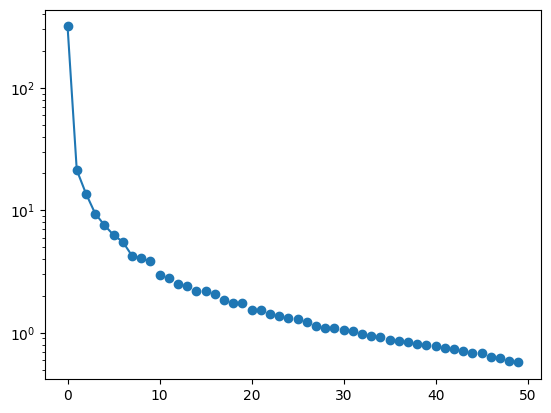

### next section is WIP : compute GD subspace, and then project the GA gradients

In [126]:
import torch

### Extract GA gradients

gradient_vectors = []
model.train()        # We need gradients from the model.
probe_model.eval()   # The probe is frozen.


layer_ind = 8
gradient_vectors = []
model.train()        # Ensure gradients are computed for the model.
probe_model.eval()   # The probe remains frozen.

# Find the target layer using the provided layer index.

for probe_ind, (images, labels) in enumerate(probe_loader):
    images = images.to(device)
    labels = labels.to(device)
    for image, label in zip(images, labels):
        optimizer.zero_grad()
        model.zero_grad()
        # Forward pass through model to get embeddings
        # unsqueeze to add batch dimension
        image = image.unsqueeze(0).to(device)
        label = label.unsqueeze(0).to(device)
        embeddings = get_flattened_embedding__model(model, image, layer_ind=layer_ind)

        # Forward pass through probe (frozen)
        predictions = probe_model(embeddings)
        # squeeze predictions
        predictions = predictions.squeeze()

        # predictions 
        # Compute loss
        loss = criterion(predictions, label)
        ascent_loss = -1 * loss
        ascent_loss.backward()
        # Backward pass: updates model only, probe is frozen
        ####
        # Extract gradients from the target layer.
        grads = flatten_layer_gradients(model, layer_ind-1) # hack - cause 7 and 8 are differnet
        if grads is not None:
            grad_vector = grads.detach().cpu().numpy()
            gradient_vectors.append(grad_vector)
 
        # TODO compute the positive subspace
        # TODO - project these gradients onto the positive subspace
        
        # put the gradients back
        unflatten_gradients(grads, get_layer(model, layer_ind-1))

    # Optionally update the probe model.
    optimizer.step()

    break 



In [131]:
#grads = flatten_layer_gradients(model, 7)

len(gradient_vectors)#.shape
gradient_vectors[0].shape





(14964736,)

In [105]:
layer_ = get_layer(model, layer_ind-1)

for p in layer_.parameters():
    print(f"{p.grad.shape} - {p.grad.flatten().shape}")




torch.Size([512, 1024, 1, 1]) - torch.Size([524288])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([512, 512, 3, 3]) - torch.Size([2359296])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([2048, 512, 1, 1]) - torch.Size([1048576])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048, 1024, 1, 1]) - torch.Size([2097152])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048]) - torch.Size([2048])
torch.Size([512, 2048, 1, 1]) - torch.Size([1048576])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([512, 512, 3, 3]) - torch.Size([2359296])
torch.Size([512]) - torch.Size([512])
torch.Size([512]) - torch.Size([512])
torch.Size([2048, 512, 1, 1]) - torch.Size([1048576])
torch.Size([2048]) - torch.Size([2048])
torch.Size([2048]) - torch.Size([2048])
torch.Size([512, 2048, 1, 1]) - torch.Size([1048576])
torch.Size([512]) - torch.

In [104]:
p.flatten().shape

torch.Size([2048])

torch.Size([14964736])

## Can we project GA-steps onto GD steps for a different loss function - plot val-probe accuracy